<a href="https://colab.research.google.com/github/Qxr2427/MachineLearning-Opensource-Projects/blob/master/Face_detection_model_simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Application: A Face Detection Pipeline

Let's moving from these concepts to real-world application by building a face detection machine-learning model.
We will use HOG features to develop a simple face detection pipeline, using machine learning algorithms and concepts we've seen throughout this lecture. 

We begin with the standard imports:

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

In [0]:
#Let's get started by importing tensorflow and keras
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

1.14.0


### 1. Obtain a set of positive training samples

Let's start by finding some positive training samples that show a variety of faces.
We have one easy set of data to work with—the Labeled Faces in the Wild dataset, which can be downloaded by Scikit-Learn:

In [0]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people()
positive_patches = faces.images
positive_patches.shape

(13233, 62, 47)

(-0.5, 46.5, 61.5, -0.5)

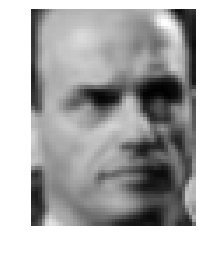

In [0]:
plt.imshow(positive_patches[6], cmap='gray')
plt.axis('off')


In [0]:
positive_patches[100].shape

(62, 47)

This gives us a sample of 13,000 face images to use for training.

### 2. Obtain a set of negative training samples

Next we need a set of similarly sized thumbnails which *do not* have a face in them.
One way to do this is to take any corpus of input images, and extract thumbnails from them at a variety of scales.
Here we can use some of the images shipped with Scikit-Image, along with Scikit-Learn's ``PatchExtractor``:

In [0]:
from skimage import data, color, feature
import skimage.data
from skimage import data, transform

imgs_to_use = ['camera', 'text', 'coins', 'moon',
               'page', 'clock', 'immunohistochemistry',
               'chelsea', 'coffee', 'hubble_deep_field']
images = [color.rgb2gray(getattr(data, name)())
          for name in imgs_to_use]

In [0]:
from sklearn.feature_extraction.image import PatchExtractor

def extract_patches(img, N, scale=1.0, patch_size=positive_patches[0].shape):
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size,
                               max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size)
                            for patch in patches])
    return patches

negative_patches = np.vstack([extract_patches(im, 1000, scale)
                              for im in images for scale in [0.5, 1.0, 2.0]])
negative_patches.shape

(30000, 62, 47)

We now have 30,000 suitable image patches which do not contain faces.
Let's take a look at a few of them to get an idea of what they look like:

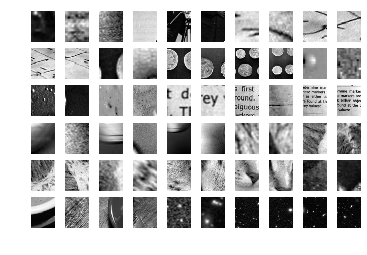

In [0]:
fig, ax = plt.subplots(6, 10)
for i, axi in enumerate(ax.flat):
    axi.imshow(negative_patches[500 * i], cmap='gray')
    axi.axis('off')

Our hope is that these would sufficiently cover the space of "non-faces" that our algorithm is likely to see.

### 3. Combine sets and extract HOG features

Now that we have these positive samples and negative samples, we can combine them and compute HOG features.
This step takes a little while, because the HOG features involve a nontrivial computation for each image:

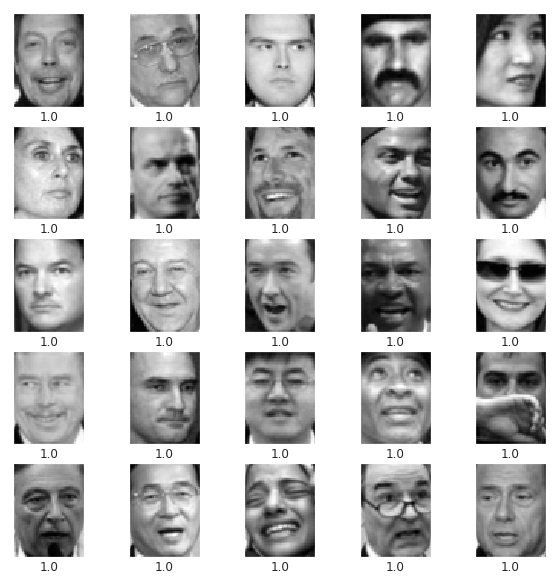

In [0]:
train_data=np.append(positive_patches,negative_patches,axis=0)
train_label = np.zeros(train_data.shape[0])
train_label[:positive_patches.shape[0]] = 1
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_data[i], cmap='gray')
    plt.xlabel(train_label[i])
plt.show()


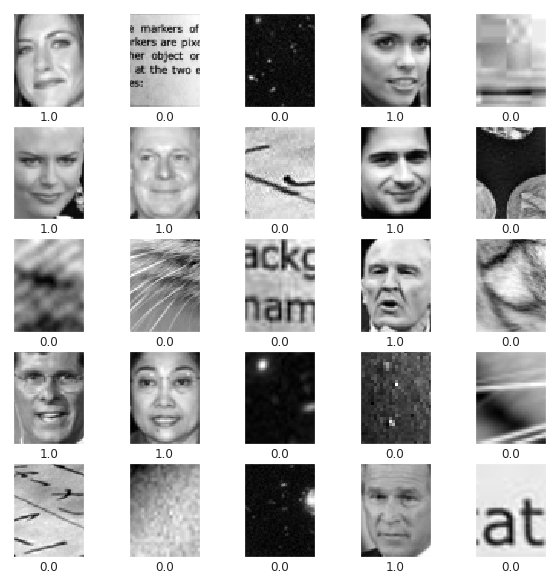

In [0]:

combine_data=list(zip(train_data,train_label))

np.random.shuffle(combine_data)

train_data,train_label=zip(*combine_data)
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_data[i], cmap='gray')
    plt.xlabel(train_label[i])
plt.show()


In [0]:
train_data=np.array(train_data)
train_label=np.array(train_label)

test_data=train_data[:10000]
test_label=train_label[:10000]

train_data=train_data[10000:]
train_label=train_label[10000:]


print(train_data.shape)
print(train_label.shape)
print(test_data.shape)
print(test_label.shape)

(33233, 62, 47)
(33233,)
(10000, 62, 47)
(10000,)


### 4. Training a support vector machine

Next we use the tools we have been exploring in this chapter to create a classifier of thumbnail patches.
For such a high-dimensional binary classification task, a Linear support vector machine is a good choice.
We will use Scikit-Learn's ``LinearSVC``, because in comparison to ``SVC`` it often has better scaling for large number of samples.

First, though, let's use a simple Gaussian naive Bayes to get a quick baseline:

In [0]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(62, 47)),
    keras.layers.Dense(128, activation=tf.nn.relu,input_shape=(1215,)),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

model.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['accuracy', 'binary_crossentropy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 2914)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               373120    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 373,249
Trainable params: 373,249
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = model.fit(                  train_data,
                                      train_label,
                                      epochs=5,
                                      batch_size=512,
                                      validation_data=(test_data, test_label),
                                      verbose=2)

Train on 33233 samples, validate on 10000 samples
Epoch 1/5
33233/33233 - 3s - loss: 58.9851 - acc: 0.6963 - binary_crossentropy: 58.9851 - val_loss: 0.7992 - val_acc: 0.9394 - val_binary_crossentropy: 0.7992
Epoch 2/5
33233/33233 - 2s - loss: 0.5474 - acc: 0.9588 - binary_crossentropy: 0.5474 - val_loss: 0.3796 - val_acc: 0.9614 - val_binary_crossentropy: 0.3796
Epoch 3/5
33233/33233 - 2s - loss: 0.3180 - acc: 0.9686 - binary_crossentropy: 0.3180 - val_loss: 0.2996 - val_acc: 0.9727 - val_binary_crossentropy: 0.2996
Epoch 4/5
33233/33233 - 2s - loss: 0.2761 - acc: 0.9730 - binary_crossentropy: 0.2761 - val_loss: 0.2706 - val_acc: 0.9743 - val_binary_crossentropy: 0.2706
Epoch 5/5
33233/33233 - 2s - loss: 0.2547 - acc: 0.9749 - binary_crossentropy: 0.2547 - val_loss: 0.2519 - val_acc: 0.9744 - val_binary_crossentropy: 0.2519


In [0]:
predictions = model.predict(test_data)

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


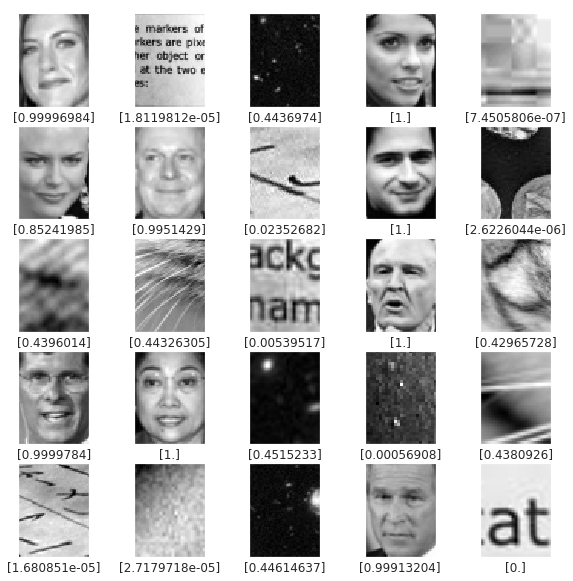

In [0]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_data[i], cmap='gray')
    plt.xlabel(predictions[i])
plt.show()

### 5. Find faces in a new image

Now that we have this model in place, let's grab a new image and see how the model does.
We will use one portion of the astronaut image for simplicity (see discussion of this in [Caveats and Improvements](#Caveats-and-Improvements)), and run a sliding window over it and evaluate each patch:

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


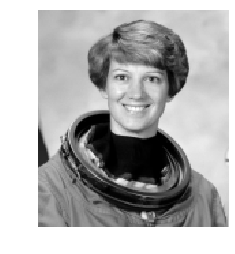

In [0]:
test_image = skimage.data.astronaut()
test_image = skimage.color.rgb2gray(test_image)
test_image = skimage.transform.rescale(test_image, 0.5)
test_image = test_image[:160, 40:180]

plt.imshow(test_image, cmap='gray')
plt.axis('off');

Next, let's create a window that iterates over patches of this image, and compute HOG features for each patch:

In [0]:
def sliding_window(img, patch_size=positive_patches[0].shape,
                   istep=2, jstep=2, scale=1.0):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size)
            yield (i, j), patch
            
indices, patches = zip(*sliding_window(test_image))

patches=np.array(patches)
patches.shape
#patches_hog = np.array([feature.hog(patch) for patch in patches])
#patches_hog.shape

(1911, 62, 47)

Finally, we can take these HOG-featured patches and use our model to evaluate whether each patch contains a face:

In [0]:
labels=model.predict(patches)
#patches[0].shape
#for i in range(patches.shape[0]):
#  labels = model.predict(,patches[i])
print(labels.shape)
labels=labels[:,0]
print(labels.shape)

(1911, 1)
(1911,)


We see that out of nearly 2,000 patches, we have found 30 detections.
Let's use the information we have about these patches to show where they lie on our test image, drawing them as rectangles:

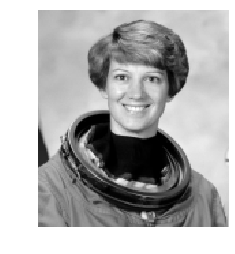

In [0]:
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

Ni, Nj = positive_patches[0].shape
indices = np.array(indices)

for i, j in indices[labels >= 0.95]:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                               alpha=0.3, lw=2, facecolor='none'))

All of the detected patches overlap and found the face in the image!
Not bad for a few lines of Python.

## Caveats and Improvements

If you dig a bit deeper into the preceding code and examples, you'll see that we still have a bit of work before we can claim a production-ready face detector.
There are several issues with what we've done, and several improvements that could be made. In particular:

### Our training set, especially for negative features, is not very complete

The central issue is that there are many face-like textures that are not in the training set, and so our current model is very prone to false positives.
You can see this if you try out the above algorithm on the *full* astronaut image: the current model leads to many false detections in other regions of the image.

We might imagine addressing this by adding a wider variety of images to the negative training set, and this would probably yield some improvement.
Another way to address this is to use a more directed approach, such as *hard negative mining*.
In hard negative mining, we take a new set of images that our classifier has not seen, find all the patches representing false positives, and explicitly add them as negative instances in the training set before re-training the classifier.

### Our current pipeline searches only at one scale

As currently written, our algorithm will miss faces that are not approximately 62×47 pixels.
This can be straightforwardly addressed by using sliding windows of a variety of sizes, and re-sizing each patch using ``skimage.transform.resize`` before feeding it into the model.
In fact, the ``sliding_window()`` utility used here is already built with this in mind.

### We should combine overlapped detection patches

For a production-ready pipeline, we would prefer not to have 30 detections of the same face, but to somehow reduce overlapping groups of detections down to a single detection.
This could be done via an unsupervised clustering approach (MeanShift Clustering is one good candidate for this), or via a procedural approach such as *non-maximum suppression*, an algorithm common in machine vision.

### The pipeline should be streamlined

Once we address these issues, it would also be nice to create a more streamlined pipeline for ingesting training images and predicting sliding-window outputs.
This is where Python as a data science tool really shines: with a bit of work, we could take our prototype code and package it with a well-designed object-oriented API that give the user the ability to use this easily.
I will leave this as a proverbial "exercise for the reader".

### More recent advances: Deep Learning

Finally, I should add that HOG and other procedural feature extraction methods for images are no longer state-of-the-art techniques.
Instead, many modern object detection pipelines use variants of deep neural networks: one way to think of neural networks is that they are an estimator which determines optimal feature extraction strategies from the data, rather than relying on the intuition of the user.
An intro to these deep neural net methods is conceptually (and computationally!) beyond the scope of this section, although open tools like Google's [TensorFlow](https://www.tensorflow.org/) have recently made deep learning approaches much more accessible than they once were.
As of the writing of this book, deep learning in Python is still relatively young, and so I can't yet point to any definitive resource.
That said, the list of references in the following section should provide a useful place to start!

<!--NAVIGATION-->
< [In-Depth: Kernel Density Estimation](05.13-Kernel-Density-Estimation.ipynb) | [Contents](Index.ipynb) | [Further Machine Learning Resources](05.15-Learning-More.ipynb) >

<a href="https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.14-Image-Features.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>
